In [1]:
import numpy as np
%pylab inline
from sklearn.metrics import *
from sklearn.cluster import DBSCAN
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv("abalone.data.txt", header=None)
df.head()

,0,1,2,3,4,5,6,7,8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
sex_unique_vals = df[0].unique()
sex_mapping = dict( zip( sex_unique_vals, range(len(sex_unique_vals)) ) )
print sex_mapping

{'I': 2, 'M': 0, 'F': 1}


In [4]:
df[0].replace(sex_mapping, inplace=True)

## Outlier detection, con DBSCAN 

In [43]:
xx = np.linspace(0.01, 1.00, 200)
yy = list()
for eps in xx:
    dbscan = DBSCAN(eps, min_samples=5, metric='euclidean')
    dbscan.fit(df)
    labels = dbscan.labels_
    # yy = size of noise cluster
    yy.append(float(len([1 for i in labels if i == -1])) / len(df.values))

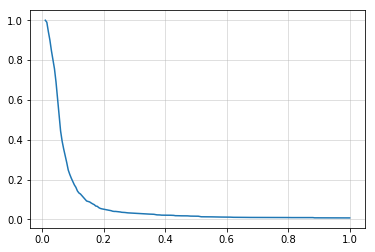

In [44]:
plt.grid(alpha=0.5)
plt.plot(xx, yy)

In [45]:
my_eps = min( [ xx[i] for i in range(len(xx)) if yy[i]<=0.01 ] )
print my_eps

0.6666834170854271


In [52]:
import outliers

In [55]:
results = []
for min_pts in [3,4,5]:
    xx, yy, my_eps = outliers.dbscan_search(df, min_pts)
    results.append((min_pts, xx, yy, my_eps))

0.4328643216080402
0.5273869346733668
0.6666834170854271


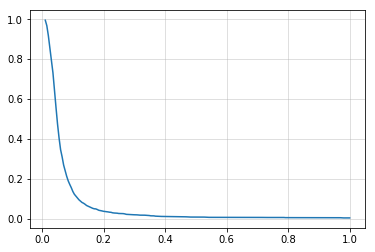

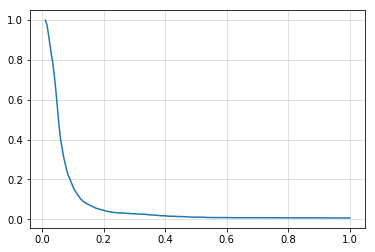

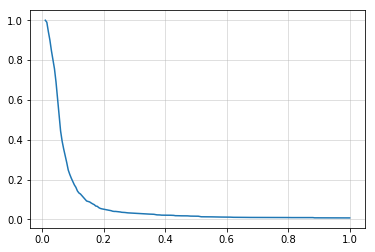

In [58]:
for r in results:
    plt.figure()
    plt.grid(alpha=0.5)
    plt.plot(r[0], r[1])
    print r[2]

In [67]:
dbscan = DBSCAN(results[2][2], min_samples=5, metric='euclidean')
dbscan.fit(df)
labels = dbscan.labels_

In [59]:
pca = PCA(n_components=2)
X_scaled_2D = pca.fit_transform(df)
noise = array([ df.values[i] for i in range(len(df.values)) if labels[i]==-1])
noise_rows = array([ i for i in range(len(df.values)) if labels[i]==-1])
noise_scaled = pca.fit_transform(noise)
print len(noise_rows)

25


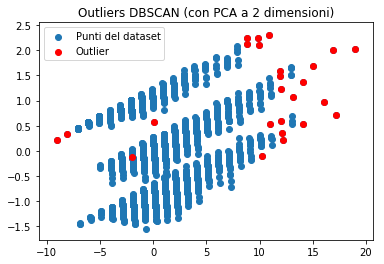

In [88]:
plt.scatter(X_scaled_2D[:,0], X_scaled_2D[:,1])
plt.scatter(X_scaled_2D[noise_rows,0], X_scaled_2D[noise_rows,1], c='r')
plt.title("Outliers DBSCAN (con PCA a 2 dimensioni)")
plt.legend(["Punti del dataset", "Outlier"])

In [68]:
pca = PCA(n_components=3)
X_scaled_3D = pca.fit_transform(df)
noise = array([ df.values[i] for i in range(len(df.values)) if labels[i]==-1])
noise_rows = array([ i for i in range(len(df.values)) if labels[i]==-1])
noise_scaled = pca.fit_transform(noise)

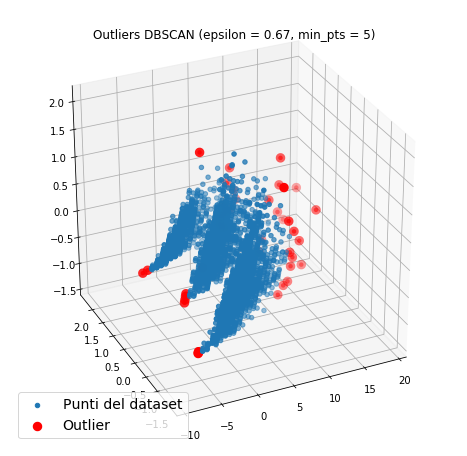

In [71]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(X_scaled_3D[:,0], X_scaled_3D[:,1], X_scaled_3D[:,2])
all_rows = range(len(df.values))
good_rows = list(set(all_rows) - set(noise_rows))
ax.scatter(X_scaled_3D[good_rows,0], X_scaled_3D[good_rows,1], X_scaled_3D[good_rows,2])
ax.scatter(X_scaled_3D[noise_rows,0], X_scaled_3D[noise_rows,1], X_scaled_3D[noise_rows,2], c='r', linewidths=5)
ax.view_init(30, 245)
plt.title("Outliers DBSCAN (epsilon = %.2f, min_pts = %d)" % (results[2][2], 5))
plt.legend(["Punti del dataset", "Outlier"], loc="lower left",prop={'size': 14})

## Outlier detection, con approccio Angle-based (troppo lento)

In [12]:
from multiprocessing.pool import ThreadPool

pool = ThreadPool(processes=8)

In [ ]:
res = pool.imap(lambda x: if x>1: return x*x, [1,2,3])
print list(res)

In [16]:
def body((a,b,angles)):
    pa = a - p
    pb = b - p
    norm_pa = np.linalg.norm(pa)
    norm_pb = np.linalg.norm(pb)
    if norm_pa*norm_pb > 0:
        c_ang = np.dot(pa, pb) / (norm_pa**2 * norm_pb**2)
        angles.append(c_ang)
    return angles

In [21]:
import itertools
list(itertools.product(range(2), range(2), [list()]))

a = []
a.extend([4,5])
print a

[4, 5]


In [ ]:
abod = list()
for p in df.values:
    pool = ThreadPool(processes=8)
    angle_list = list()
    results = []
    
    '''
    for a in df.values:
        for b in df.values:
            async_result = pool.apply_async(body, (a,b,angle_list))
            results.append(async_result)
    '''
    args = itertools.product(df.values, df.values, [list()])
    res = pool.imap(body, args)
    '''
    for r in results:
        angle_list.extend(r.get())
    '''        
    angle_list.extend(list(res))
    pool.close()
    pool.join()
    results = []
    
    abod.append( np.var(angle_list) )

In [112]:
# compute ABOD score for each point
# -- O(n^3) ==> very slow!
"""abod = list()
for p in df.values:
    angle_list = list()
    for a in df.values:
        for b in df.values:
            pa = a - p
            pb = b - p
            norm_pa = np.linalg.norm(pa)
            norm_pb = np.linalg.norm(pb)
            if norm_pa*norm_pb > 0:
                c_ang = np.dot(pa, pb) / (norm_pa**2 * norm_pb**2)
                angle_list.append(c_ang)
    abod.append( np.var(angle_list) )"""

'abod = list()\nfor p in df.values:\n    angle_list = list()\n    for a in df.values:\n        for b in df.values:\n            pa = a - p\n            pb = b - p\n            norm_pa = np.linalg.norm(pa)\n            norm_pb = np.linalg.norm(pb)\n            if norm_pa*norm_pb > 0:\n                c_ang = np.dot(pa, pb) / (norm_pa**2 * norm_pb**2)\n                angle_list.append(c_ang)\n    abod.append( np.var(angle_list) )'

In [ ]:
# Select 1% smallest scores as outliers
take_top_n = len(df.values) / 100
abod_threshold = sorted(abod)[take_top_n]
outliers = array([ df.values[i] for i in range(len(df.values)) if abod[i]<abod_threshold])
outliers_rows = array([ i for i in range(len(df.values)) if abod[i]<abod_threshold])

In [ ]:
pca = PCA(n_components=3)
X_scaled_3D = pca.fit_transform(df)

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(X_scaled_3D[:,0], X_scaled_3D[:,1], X_scaled_3D[:,2])
all_rows = range(len(df.values))
good_rows = list(set(all_rows) - set(outliers_rows))
ax.scatter(X_scaled_3D[good_rows,0], X_scaled_3D[good_rows,1], X_scaled_3D[good_rows,2])
ax.scatter(X_scaled_3D[outliers_rows,0], 
           X_scaled_3D[outliers_rows,1], 
           X_scaled_3D[outliers_rows,2], 
           c='r', linewidths=5)
plt.title("Angle-based outliers (con PCA a 3 dimensioni)")
plt.legend(["Punti del dataset", "Outlier"], loc="lower left",prop={'size': 14})

## Outlier detection con LOF 

In [75]:
from sklearn.neighbors import LocalOutlierFactor

In [86]:
clf = LocalOutlierFactor(n_neighbors=10)
y_pred = clf.fit_predict(df)

In [87]:
one_percent_outliers = sorted(zip(clf.negative_outlier_factor_, 
                                  [i for i in range(len(df.values))])
                             )[:len(df.values) / 100]
one_percent_outliers_rows = [r[1] for r in one_percent_outliers]
print one_percent_outliers_rows

[2206, 236, 514, 521, 2051, 719, 2167, 3996, 2627, 1216, 2641, 3086, 1210, 3982, 526, 2371, 3814, 3928, 1209, 3716, 1881, 1207, 1051, 1264, 1228, 2811, 2537, 1426, 2127, 2975, 3188, 520, 3718, 1206, 2728, 1257, 2420, 480, 2790, 1184, 3717]


In [88]:
pca = PCA(n_components=3)
X_scaled_3D = pca.fit_transform(df)
noise = array([ df.values[i] for i in range(len(df.values)) if y_pred[i]==-1])
noise_rows = array([ i for i in range(len(df.values)) if y_pred[i]==-1])
#noise_scaled = pca.fit_transform(noise)
noise_rows = one_percent_outliers_rows
len(noise_rows)

41

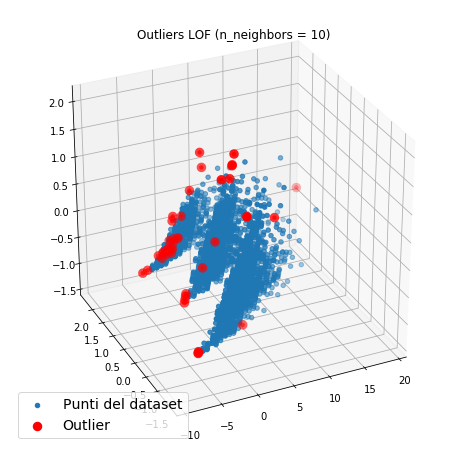

In [90]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(X_scaled_3D[:,0], X_scaled_3D[:,1], X_scaled_3D[:,2])
all_rows = range(len(df.values))
good_rows = list(set(all_rows) - set(noise_rows))
ax.scatter(X_scaled_3D[good_rows,0], 
           X_scaled_3D[good_rows,1], 
           X_scaled_3D[good_rows,2])
ax.scatter(X_scaled_3D[noise_rows,0], 
           X_scaled_3D[noise_rows,1], 
           X_scaled_3D[noise_rows,2], 
           c='r', 
           linewidths=5)
ax.view_init(30, 245)
plt.title("Outliers LOF (n_neighbors = 10)")
plt.legend(["Punti del dataset", "Outlier"], loc="lower left",prop={'size': 14})
plt.show()

## Depth-based outlier detection

In [35]:
from scipy.spatial import ConvexHull

In [36]:
pca = PCA(n_components=3)
X_scaled_3D = pca.fit_transform(df)

hull = ConvexHull(X_scaled_3D)

In [37]:
(hull.vertices)

array([ 236,  246,  294,  480,  518,  520,  523,  525,  526,  542,  547,
        611,  619,  628,  646,  660,  664,  673,  675,  891, 1098, 1102,
       1201, 1209, 1417, 1426, 1528, 1763, 2108, 2114, 2209, 2334, 2343,
       2371, 2381, 2416, 2417, 2678, 2811, 3325, 3359, 3518, 3906, 3928,
       3996], dtype=int32)

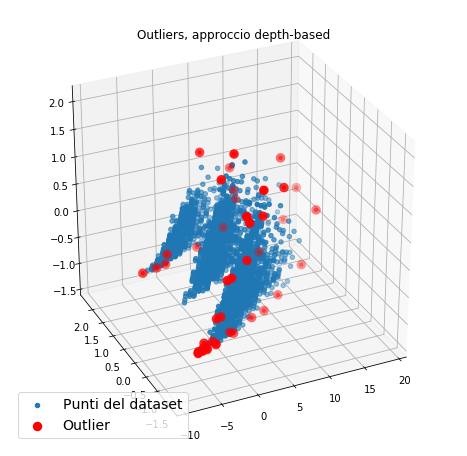

In [91]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(X_scaled_3D[:,0], X_scaled_3D[:,1], X_scaled_3D[:,2])
all_rows = range(len(df.values))
good_rows = list(set(all_rows) - set(hull.vertices))
ax.scatter(X_scaled_3D[good_rows,0], 
           X_scaled_3D[good_rows,1], 
           X_scaled_3D[good_rows,2])
ax.scatter(X_scaled_3D[hull.vertices,0], 
           X_scaled_3D[hull.vertices,1], 
           X_scaled_3D[hull.vertices,2], 
           c='r', 
           linewidths=5)
ax.view_init(30, 245)
plt.title("Outliers, approccio depth-based")
plt.legend(["Punti del dataset", "Outlier"], loc="lower left",prop={'size': 14})